## Periodontal Diease Model ##
### Predictions and performance evaluation for the test set ###
This notebook relies on the data and model checkpoint.

Please run notebook 01 to download the model weights and image data.

In [1]:
import os
import re
import ast
import tarfile
import pandas as pd
import numpy as np
import logging
import shutil
import glob
from pathlib import Path
import random
from matplotlib import pyplot as plt
from matplotlib import colormaps
import albumentations as alb
import itertools

# Scikit-learn performance metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc as calculate_auc

# PyTorch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

logger = logging.getLogger(name=__name__)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of the output plots
plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Imports from this project
%load_ext autoreload
%autoreload 2
import periomodel
from periomodel.fileutils import FileOP
from periomodel.imageproc import is_image
from periomodel.models.perio1 import PerioModel
from periomodel.torchdataset import DatasetFromDF, TorchDataset, augmentations
print(f'Module version:  {periomodel.__version__}')
print(f'PyTorch version: {torch.__version__}')

Module version:  0.0.post1.dev19+gf9f2c51
PyTorch version: 2.4.1+cu121


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')
# Set precision
torch.set_float32_matmul_precision('medium')

CUDA available: False
Number of GPUs found:  0

Device for model training/inference: cpu


### Some useful functions for this notebook ###

In [3]:
def patient_image_stat(data, file_col='file', group_col='group'):
    df_n_patients = data[['PatientIDE', group_col]].\
                    drop_duplicates().\
                    groupby(by=group_col).nunique().\
                    reset_index(drop=False).\
                    rename(columns={'PatientIDE': 'n_patients'}).\
                    sort_values(by=group_col, ascending=True).\
                    reset_index(drop=True)

    df_n_images = data[[file_col, group_col]].\
                drop_duplicates().\
                groupby(by=group_col).nunique().\
                reset_index(drop=False).\
                rename(columns={file_col: 'n_images'}).\
                sort_values(by=group_col, ascending=True).\
                reset_index(drop=True)

    df_stat = df_n_patients.merge(df_n_images, on=group_col, how='inner')
    df_stat = df_stat.assign(images_per_patient=np.round(df_stat['n_images']/df_stat['n_patients']).astype(int))

    return df_stat

### Define the locations of the model checkpoint and image data ###
Access to the test data requires a URL and AWS access keys which can be obtained from the authors of the manuscript.

In [4]:
data_dir = os.environ.get('DATA_ROOT')
assert os.path.isdir(data_dir), f'data_dir {data_dir} does not exist.'
image_dir = os.path.join(data_dir, 'periodata_test', 'test')
model_dir = os.path.join(data_dir, 'periomodel_checkpoint_1400')

image_files = glob.glob(os.path.join(image_dir, '*.png'))
print(f'{len(image_files)} images found in {image_dir}')

label_file = glob.glob(os.path.join(image_dir, '*.parquet'))
assert len(label_file) > 0, f'.parquet file not found in {image_dir}'
print(f'Loading label data from {label_file[0]}')
test_df = pd.read_parquet(label_file[0])
display(test_df.head())
# We will add the file path from the local file system
test_df = test_df.assign(file=test_df['image'].\
                         apply(lambda image_name: os.path.join(image_dir, image_name)))

checkpoint_file = glob.glob(os.path.join(model_dir, '*.ckpt'))
assert len(checkpoint_file) > 0, f'.chkpt file not found in {model_dir}'
log_file = glob.glob(os.path.join(model_dir, '*.log'))
assert len(log_file) > 0, f'.log file not found in {model_dir}'
checkpoint_file = checkpoint_file[0]
log_file = log_file[0]

# Set the output directory for the ROC/PR courves
fig_output_dir = os.path.join(model_dir, 'performance_plots')
Path(fig_output_dir).mkdir(parents=True, exist_ok=True)

614 images found in /app/data/periodata_test/test
Loading label data from /app/data/periodata_test/test/perimodel_labels_test.parquet


,PatientIDE,annotation_id,disease,cl3,dset,image
0,a5c42982,829,unstable,2,test,box_a5c42982_20230414_02_00.png
1,956a3988,1758,stable,1,test,box_956a3988_20221108_02_01.png
2,037914b7,1545,unstable,2,test,box_037914b7_20230331_21_03.png
3,c0b47799,5703,very unstable,2,test,box_c0b47799_20230208_05_05.png
4,2cfc437a,3334,stable,1,test,box_2cfc437a_20230515_11_02.png


In [5]:
# Label assignments in data set
label_dict = {}
label_dict_inv = {}
label_col_list = ['cl3']
for label_col in label_col_list:
    cl_list = sorted(list(test_df.get(label_col).unique()))
    ds_list = [tuple(test_df.loc[test_df[label_col]==cl, 'disease'].unique()) for cl in cl_list]
    label_cl_dict = dict(zip(cl_list, ds_list))
    label_dict.update({label_col: label_cl_dict})
    
    ds_list_inv = sorted(list(test_df.get('disease').unique()))
    cl_list_inv = [int(test_df.loc[test_df['disease'] == disease, label_col].\
                       values[0]) for disease in ds_list_inv]
    label_cl_dict_inv = dict(zip(ds_list_inv, cl_list_inv))
    label_dict_inv.update({label_col: label_cl_dict_inv})
display(label_dict)
print()
display(label_dict_inv)

{'cl3': {np.int64(0): ('healthy',),
  np.int64(1): ('stable',),
  np.int64(2): ('unstable', 'very unstable')}}

{'cl3': {'healthy': 0, 'stable': 1, 'unstable': 2, 'very unstable': 2}}

### Load the model parameters from the log file ###

In [6]:
# Model parameter
model_name = 'periocl3_128'
model_version_number = 1
model_version = f'version_{model_version_number}'
label_col = 'cl3'
labels = label_dict.get(label_col)

# Disease labels
disease_labels = label_dict.get(label_col)

max_im_size = 2500
im_size = 512
batch_size = 16

# Now, we can calculate the number of batches that we need to push through the model
n_batches = int(np.ceil(len(test_df['image'].unique()) / batch_size))

In [7]:
# Open log file for this model
print(log_file)
with open(log_file, 'r') as fl:
    log = fl.read()
params = ast.literal_eval(re.search('({.+})', log).group(0))
display(params)

im_mean = params.get('im_mean')
im_std = params.get('im_std')
gray = params.get('gray')

/app/data/periomodel_checkpoint_1400/train.log


{'max_epochs': 3000,
 'batch_size': 128,
 'augment': 'augment_1',
 'dataset': 'periodata_240415',
 'learning_rate': 0.0002,
 'max_im_size': 2500,
 'num_workers': 8,
 'im_size': 512,
 'im_mean': 0,
 'im_std': 1,
 'hist_eq': True,
 'gray': True,
 'n_hidden': 128,
 'model': 'xrv',
 'model_name': 'periocl3_128',
 'model_version': 1,
 'checkpoint_every_n_epoch': 100,
 'checkpoint_monitor': 'val_loss',
 'check_val_every_n_epoch': 2,
 'save_top_k_epochs': 20,
 'file_col': 'file',
 'label_col': 'cl3',
 'comment': 'validation',
 'date': 240428,
 'model_dir': '/n/scratch/users/a/aaw10/dcmdata/model',
 'checkpoint_dir': '/n/scratch/users/a/aaw10/dcmdata/model/periocl3_128/version_1/checkpoints',
 'label_list': [0, 1, 2],
 'disease_list': [['healthy'], ['stable'], ['unstable', 'very unstable']],
 'data_file': '/n/scratch/users/a/aaw10/dcmdata/dataset/periodata_240415/periodata_240415_split_ide.parquet'}

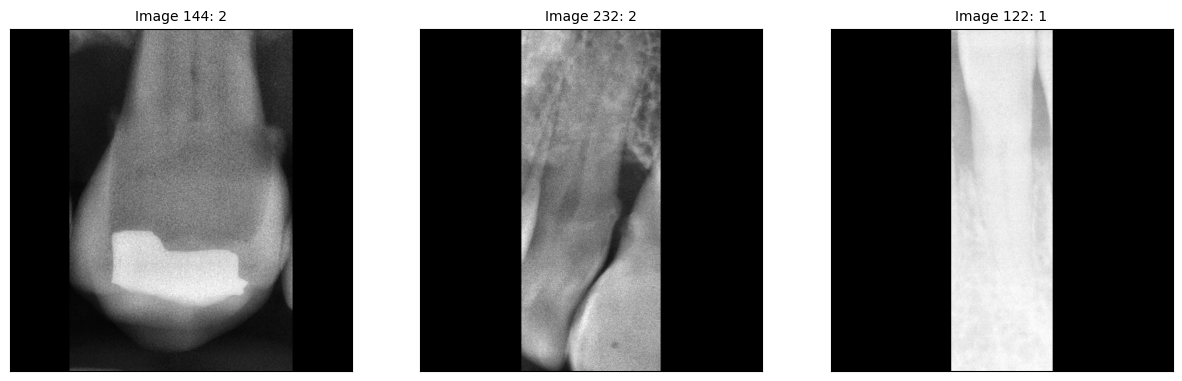

In [8]:
# Create a data set from the data frame
test_transform = augmentations(im_size=im_size, 
                               image_mean=im_mean, 
                               image_std=im_std,
                               augment=None)

test_dataset = DatasetFromDF(data=test_df,
                             file_col='file',
                             label_col=label_col,
                             max_im_size=max_im_size,
                             transform=test_transform,
                             hist_eq=True,
                             gray=gray,
                             validate=True)

dl = DataLoader(dataset=test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

# Show some test images
show_n_images = 3
image_idx_list = np.random.randint(len(test_dataset), size=show_n_images) 
image_list = [torch.squeeze(test_dataset[idx][0]).numpy() for idx in image_idx_list]
label_list = [test_dataset[idx][1].numpy() for idx in image_idx_list]
fig, ax = plt.subplots(nrows=1, ncols=show_n_images, figsize=(15, 5))
for i, im in enumerate(image_list):
    if gray:
        ax[i].imshow(im, cmap='gray')
    else:
        im = np.transpose(im, (1, 2, 0))
        ax[i].imshow(im)
    ax[i].set(xticks=[], yticks=[])
    ax[i].set_title(f'Image {image_idx_list[i]}: {label_list[i]}')
plt.show()

### Run model predictions on testset ###

In [10]:
# Check if the predictions are already there.
predictions_file_name = f'predictions_{model_name}_{model_version_number}.parquet'
predictions_file = os.path.join(model_dir, predictions_file_name)

if not os.path.exists(predictions_file):
    print(f'Running model for checkpoint {os.path.basename(checkpoint_file)}')
    perio_model = PerioModel.load_from_checkpoint(checkpoint_file,
                                                  test_set=test_dataset,
                                                  train_set=None,
                                                  val_set=None,
                                                  batch_size=batch_size,
                                                  num_workers=1)
    sm = nn.Softmax(dim=1)
    # Predict on the test set
    pred_df_batch_list = []
    for i, (image_batch, label_batch) in enumerate(dl):
        print(f'Running batch {i + 1} / {n_batches} on device "{device_str}"')
        pred_df_batch = pd.DataFrame(sm(perio_model(image_batch.to(device))).detach().cpu().numpy())
        pred_df_batch.columns = [f'prob_{cl}' for cl in pred_df_batch.columns]
        pred_df_batch = pred_df_batch.assign(true_cl=list(label_batch.detach().numpy()))
        pred_df_batch_list.append(pred_df_batch)
    pred_df = pd.concat(pred_df_batch_list, axis=0, ignore_index=True)
    pred_df = pred_df.assign(disease=test_df['disease'].values,
                             PatientIDE=test_df['PatientIDE'].values,
                             file=test_df['file'].values,
                             checkpoint=os.path.basename(checkpoint_file),
                             model=model_name,
                             version=model_version_number)
    # Save predictions
    pred_df.to_parquet(predictions_file)
    print(f'Saved predictions: {predictions_file}')
else:
    print(f'Loading predictions from "{predictions_file}"')
    pred_df = pd.read_parquet(predictions_file)

#display(pred_df.head())
print(pred_df.shape)

Loading predictions from "/app/data/periomodel_checkpoint_1400/predictions_periocl3_128_1.parquet"
(614, 10)


### Binary test performance ###
Evaluate the models as binary classification task

In [11]:
def flatten(xss):
    """
    Args:
        xss (List[List]): List of lists to be flattened.
    Returns:
        List: Flattened list.
    """
    return [x for xs in xss for x in xs]

def list_combinations(input_list):
    """
    Args:
        input_list: A list of elements from which combinations are to be generated.
    Returns:
        output_list: A list of all possible combinations of elements from the input_list.
    """
    n = len(input_list)
    if n > 1:
        output_list = flatten([list(itertools.combinations(input_list, i)) for i in range(1, n + 1)])
    else:
        output_list = [input_list]
    return output_list

def disease_comparisons(positive_class, disease_dict):
    """
    Args:
        positive_class: The disease class for which to compare diseases.
        disease_dict: A dictionary containing disease classes as keys and their corresponding disease labels as values.
    Returns:
        A dictionary containing the positive disease cases and negative disease cases.
    """
    # disease dict {class: disease label}
    cl_list = disease_dict.keys()
    positive_disease_cases = list_combinations(disease_dict.get(positive_class))
    negative_disease_cases = list_combinations(flatten([disease_dict.get(cl) for cl in cl_list if cl != positive_class]))
    output_dict = {'positive_cases': positive_disease_cases, 
                   'negative_cases': negative_disease_cases}
    return output_dict

def join_str_list(str_list, sep='_'):
    return sep.join(str_list).replace(' ', '')

def f1_scores(pres, recs, thresholds):
    """
    Args:
        pres: A list of precision values calculated using the precision_recall_curve function.
        recs: A list of recall values calculated using the precision_recall_curve function.
        thresholds: A list of threshold values used in the precision_recall_curve function.
    Returns:
        f1_df: A pandas DataFrame containing F1 scores calculated for each threshold.
    """
    # Use the ouput of the precision_recall_curve function as the input
    # F1 scores for all thresholds
    f1_dict = {'precision': pres[:-1],
               'recall': recs[:-1],
               'thresh': thresholds}
    f1_df = pd.DataFrame(f1_dict)
    f1_df = f1_df.assign(f1=2 * (f1_df['precision'] * f1_df['recall']) / (f1_df['precision'] + f1_df['recall']))
    f1_df = f1_df.dropna(subset='f1')
    return f1_df

# plot the ROC curve
def plot_roc(fpr, tpr, label='roc', ax=None, color='b'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=False)
    ax.plot(fpr, tpr, color=color, linewidth=1.5, alpha=1.0, label=label)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0, 1.2, 0.2),
           xlabel='False positive rate (1 - specificity)', ylabel='True positive rate (sensitivity)')
    ax.plot([0.05, 0.95], [0.05, 0.95], 
            transform=ax.transAxes, color='k', linewidth=2, alpha=0.8, linestyle=':')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(0, 1.1), loc='upper left', fontsize=SMALL_SIZE)
    return ax

# plot the PR curve
def plot_pr(rec, pre, ns_pre=0.0, label='pr', ax=None, color='b'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=False)
    ax.plot(rec, pre, color=color, linewidth=1.5, alpha=1.0, label=label)
    ax.axhline(y=ns_pre, color='k', linewidth=2, alpha=0.8, linestyle=':')
    ax.set(xlim=[-0.05, 1.05], ylim=[0.0, 1.05],
           xticks=np.arange(0.0, 1.2, 0.2), yticks=np.arange(0.0, 1.2, 0.2),
           xlabel='True positive rate (sensitivity)', ylabel='Precision')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(0, 1.1), loc='upper left', fontsize=SMALL_SIZE)
    return ax


def find_list_index(input_list, input_value):
    """ find the index of the value that is closest to the input value """
    idx = list(input_list).index(min(input_list, key=lambda x:abs(x - input_value)))
    return idx

In [12]:
# Create dataset permutations
pos_cl_list = sorted(list(labels.keys()))
ds_list = [labels.get(pos) for pos in pos_cl_list]
pos_cl = 0
pos_disease_list_cases = list_combinations(labels.get(pos_cl))
neg_disease_list_cases = list_combinations(flatten([labels.get(cl) for cl in pos_cl_list if cl != pos_cl]))
# Let's just take a couple of cases for demonstration purposes
cases_dict = disease_comparisons(positive_class=pos_cl, disease_dict=labels)
display(cases_dict)

{'positive_cases': [('healthy',)],
 'negative_cases': [('stable',),
  ('unstable',),
  ('very unstable',),
  ('stable', 'unstable'),
  ('stable', 'very unstable'),
  ('unstable', 'very unstable'),
  ('stable', 'unstable', 'very unstable')]}

In [13]:
def performance_metrics(y_true, y_pred, test_pred_stat, sensitivity=0.7):
    """
    Calculates various performance metrics for classification models.
    Args:
        y_true: 1-dimensional array-like or list of true labels.
        y_pred: 1-dimensional array-like or list of predicted probabilities.
    Returns:
        Tuple containing two dictionaries:
            - metrics_dict: Contains calculated performance metrics.
            - roc_dict: Contains ROC curve data.
    """
    # Calculate performance metrics
    # ROC and AUC for ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true=y_true, y_score=y_pred)
    auc = np.round(roc_auc_score(y_true=y_true, y_score=y_pred), decimals=decimals)
    roc_idx = find_list_index(input_list=tpr, input_value=sensitivity)
    # ROC values at defined sensitivity
    fpr_s = fpr[roc_idx]
    tpr_s = tpr[roc_idx]
    roc_thresholds_s = roc_thresholds[roc_idx]
    # For this threshold, calculate the confusion matrix
    y_pred_cl = np.array([1 if pred >= roc_thresholds_s else 0 for pred in y_pred])
    conf = confusion_matrix(y_true=y_true, y_pred=y_pred_cl, normalize=None)
    TN = conf[0, 0]
    FN = conf[1, 0]
    TP = conf[1, 1]
    FP = conf[0, 1]
    n_actual_pos = len(y_true[y_true == 1])
    n_actual_neg = len(y_true[y_true == 0])
    n_pred_pos = len(y_pred_cl[y_pred_cl == 1])
    n_pred_neg = len(y_pred_cl[y_pred_cl == 0])
     
    # P-R and AUC for P-R
    pre, rec, pre_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    # Calculate the precision when we set all predictions positive (threshold=0)
    min_precision = np.round(len(y_true[y_true==1]) / len(y_true), decimals=decimals)
    auc_pre = np.round(calculate_auc(x=rec, y=pre), decimals=decimals)
    # P-R values at defined sensitivity
    pre_idx = find_list_index(input_list=rec, input_value=sensitivity)
    pre_s = pre[pre_idx]
    # Is this model useful
    useful_model = 1 if (pre_s > min_precision) & (auc > 0.5) else 0
    rec_s = rec[pre_idx]
    pre_thresholds_s = pre_thresholds[pre_idx]
    f1_s = 2 * pre_s * rec_s / (pre_s + rec_s)
    f1_df = f1_scores(pres=pre, recs=rec, thresholds=pre_thresholds)
    
    # Get precision, recall at maximum F1
    f1_max = dict(f1_df.loc[f1_df['f1'] == f1_df['f1'].max()].iloc[0])
    precision_f1_max = np.round(f1_max.get('precision'), decimals=decimals)
    recall_f1_max = np.round(f1_max.get('recall'), decimals=decimals)
    thresh_f1_max = np.round(f1_max.get('thresh'), decimals=decimals)
    f1score_f1_max = np.round(f1_max.get('f1'), decimals=decimals)
    
    # Collect the results
    metrics_dict = {'roc_auc': auc,
                    'pr_auc': auc_pre,
                    'min_precision': min_precision,
                    'max_f1_thresh': thresh_f1_max,
                    'max_f1_score': f1score_f1_max,
                    'TP': TP,
                    'TN': TN,
                    'FP': FP,
                    'FN': FN,
                    'n_actual_pos': n_actual_pos,
                    'n_actual_neg': n_actual_neg,
                    'n_pred_pos': n_pred_pos,
                    'n_pred_neg': n_pred_neg,
                    'precision': pre_s,
                    'useful': useful_model,
                    'recall': rec_s,
                    'TPR': tpr_s,
                    'FPR': fpr_s,
                    'FDR': 1 - pre_s,
                    'F1': f1_s,
                    'threshold': pre_thresholds_s,
                    'n_patients_pos': test_pred_stat.loc[test_pred_stat['true'] == 1, 'n_patients'].values[0],
                    'n_patients_neg': test_pred_stat.loc[test_pred_stat['true'] == 0, 'n_patients'].values[0],
                    'n_images_pos': test_pred_stat.loc[test_pred_stat['true'] == 1, 'n_images'].values[0],
                    'n_images_neg': test_pred_stat.loc[test_pred_stat['true'] == 0, 'n_images'].values[0]}
    
    roc_dict = {'fpr' :fpr,
                'tpr' :tpr,
                'roc_thresholds': roc_thresholds,
                'pre': pre,
                'rec': rec,
                'pre_thresholds': pre_thresholds}

    return metrics_dict, roc_dict

In [15]:
# Parameters
figsize = (6, 6)
decimals = 3
recall_interval = [0.6, 0.7]
cmap = colormaps.get('Blues')
# Generate a list of colors
n_colors = 10
colors = cmap(np.linspace(0.5, 1, n_colors))

Case number: 1
Positive disease classes: healthy
Negative disease classes: unstable+veryunstable


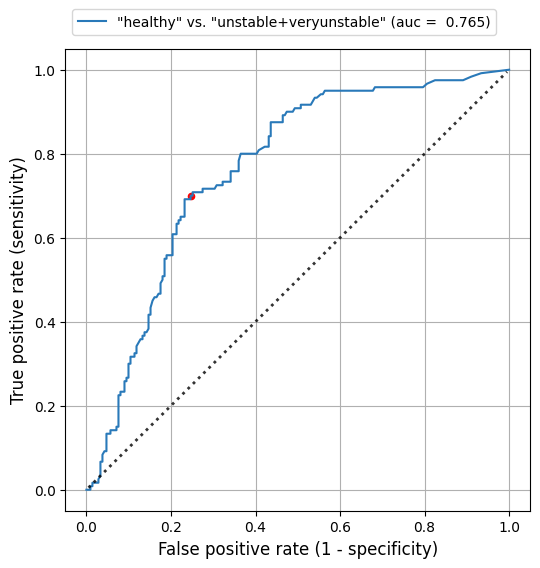

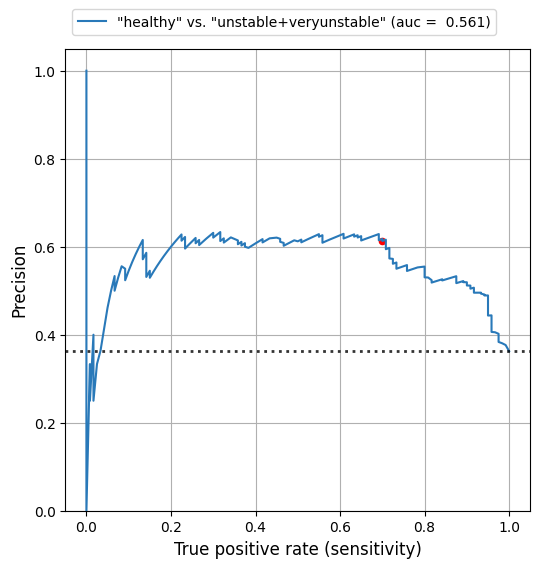

case                                                              1
model                                                  periocl3_128
version                                                           1
labels            /app/data/periodata_test/test/perimodel_labels...
positive_class                                              healthy
negative_class                                unstable_veryunstable
image_name                       1_healthy_vs_unstable_veryunstable
roc_auc                                                       0.765
pr_auc                                                        0.561
min_precision                                                 0.363
max_f1_thresh                                                 0.101
max_f1_score                                                  0.662
TP                                                               84
TN                                                              159
FP                                              

In [16]:
decimals = 3
disease_dict = label_dict.get(label_col)
sensitivity = 0.7

# Initialize a list to store the output metrics
case_metrics_df_list = []
case = 0
pos_cl = 0
    
case_dict = disease_comparisons(positive_class=pos_cl, disease_dict=disease_dict)
pos_cases = case_dict.get('positive_cases')
neg_cases = case_dict.get('negative_cases')
    
for pos_disease_list in pos_cases:
    neg_disease_list = neg_cases[5]
        
    case += 1
    
    pos_disease_str = join_str_list(pos_disease_list, sep='+')
    pos_name = join_str_list(pos_disease_list)
    
    neg_disease_str = join_str_list(neg_disease_list, sep='+')
    neg_name = join_str_list(neg_disease_list)
    
    # Set the ground truth
    pos_cl_dict = {disease: 1 for disease in pos_disease_list}
    neg_cl_dict = {disease: 0 for disease in neg_disease_list}
    print(f'Case number: {case}')
    print(f'Positive disease classes: {pos_disease_str}')
    print(f'Negative disease classes: {neg_disease_str}')
    cl_dict = pos_cl_dict.copy()
    cl_dict.update(neg_cl_dict)
    disease_list = list(cl_dict.keys())
    
    # Set the file name for the figures
    basename = f'{case}_{pos_name}_vs_{neg_name}'
    
    # Filter testset for the disease classes that we want to compare
    # Filter the checkpoint
    test_pred = pred_df.loc[(pred_df.get('disease').isin(disease_list))]
    # Set the positive and negative disease classes for binary comparisons
    test_pred = test_pred.assign(true=test_pred['disease'].apply(lambda d: cl_dict.get(d)))
    test_pred_stat = patient_image_stat(data=test_pred, file_col='file', group_col='true')
    
    # Ground truth values and model output for this test case
    y_true = test_pred.get('true').values
    y_pred = list(test_pred.get(f'prob_{pos_cl}').round(decimals=decimals).values)
    
    # Calculate the performance metrics
    metrics_dict, roc_dict = performance_metrics(y_true=y_true, 
                                                 y_pred=y_pred,
                                                 test_pred_stat=test_pred_stat,
                                                 sensitivity=sensitivity)
    
    fpr = roc_dict.get('fpr')
    tpr = roc_dict.get('tpr')
    roc_auc = metrics_dict.get('roc_auc')
    pre = roc_dict.get('pre')
    rec = roc_dict.get('rec')
    pr_auc = metrics_dict.get('pr_auc')
    min_precision = metrics_dict.get('min_precision')
    
    # Create the ROC and PR curves
    color = colors[4]
    label_base = f'"{pos_disease_str}" vs. "{neg_disease_str}"'
    
    fig, ax = plt.subplots(figsize=figsize)
    label_roc = f'{label_base} (auc = {roc_auc: .3f})'
    roc_file_name = f'roc_{basename}.png'
    roc_file = os.path.join(fig_output_dir, roc_file_name)
    ax = plot_roc(fpr=fpr, tpr=tpr, label=label_roc, ax=ax, color=color)
    ax.scatter(x=metrics_dict.get('FPR'), y=metrics_dict.get('TPR'), color='r', marker='o', s=20)
    plt.savefig(roc_file, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=figsize)
    label_pre = f'{label_base} (auc = {pr_auc: .3f})'
    pre_file_name = f'pr_{basename}.png'
    pre_file = os.path.join(fig_output_dir, pre_file_name)
    ax = plot_pr(rec=rec, pre=pre, ns_pre=min_precision, label=label_pre, ax=ax, color=color)
    ax.scatter(x=metrics_dict.get('recall'), y=metrics_dict.get('precision'), color='r', marker='o', s=20)
    plt.savefig(pre_file, bbox_inches='tight')
    plt.show()
    
    # Save the performance calculations for this case
    performance_dict = {'case': case,
                        'model': model_name,
                        'version': model_version_number,
                        'labels': label_file,
                        'positive_class': pos_name,
                        'negative_class': neg_name,
                        'image_name': basename}
    performance_dict.update(metrics_dict)
    case_df = pd.DataFrame(performance_dict, index=[0])
    case_metrics_df_list.append(case_df)
    print()
    display(case_df.iloc[0])